In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=7)
mpl.rc('xtick', labelsize=6)
mpl.rc('ytick', labelsize=6)
mpl.rc('figure', dpi=240)
plt.close('all')

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, hinge_loss, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

import seaborn as sns

In [4]:
diabetes_df=pd.read_csv("diabetes.csv")
diabetes_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
print(diabetes_df.shape)

(768, 9)


In [6]:
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [7]:
print(np.sum(diabetes_df.isna()))

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [8]:
diabetes_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


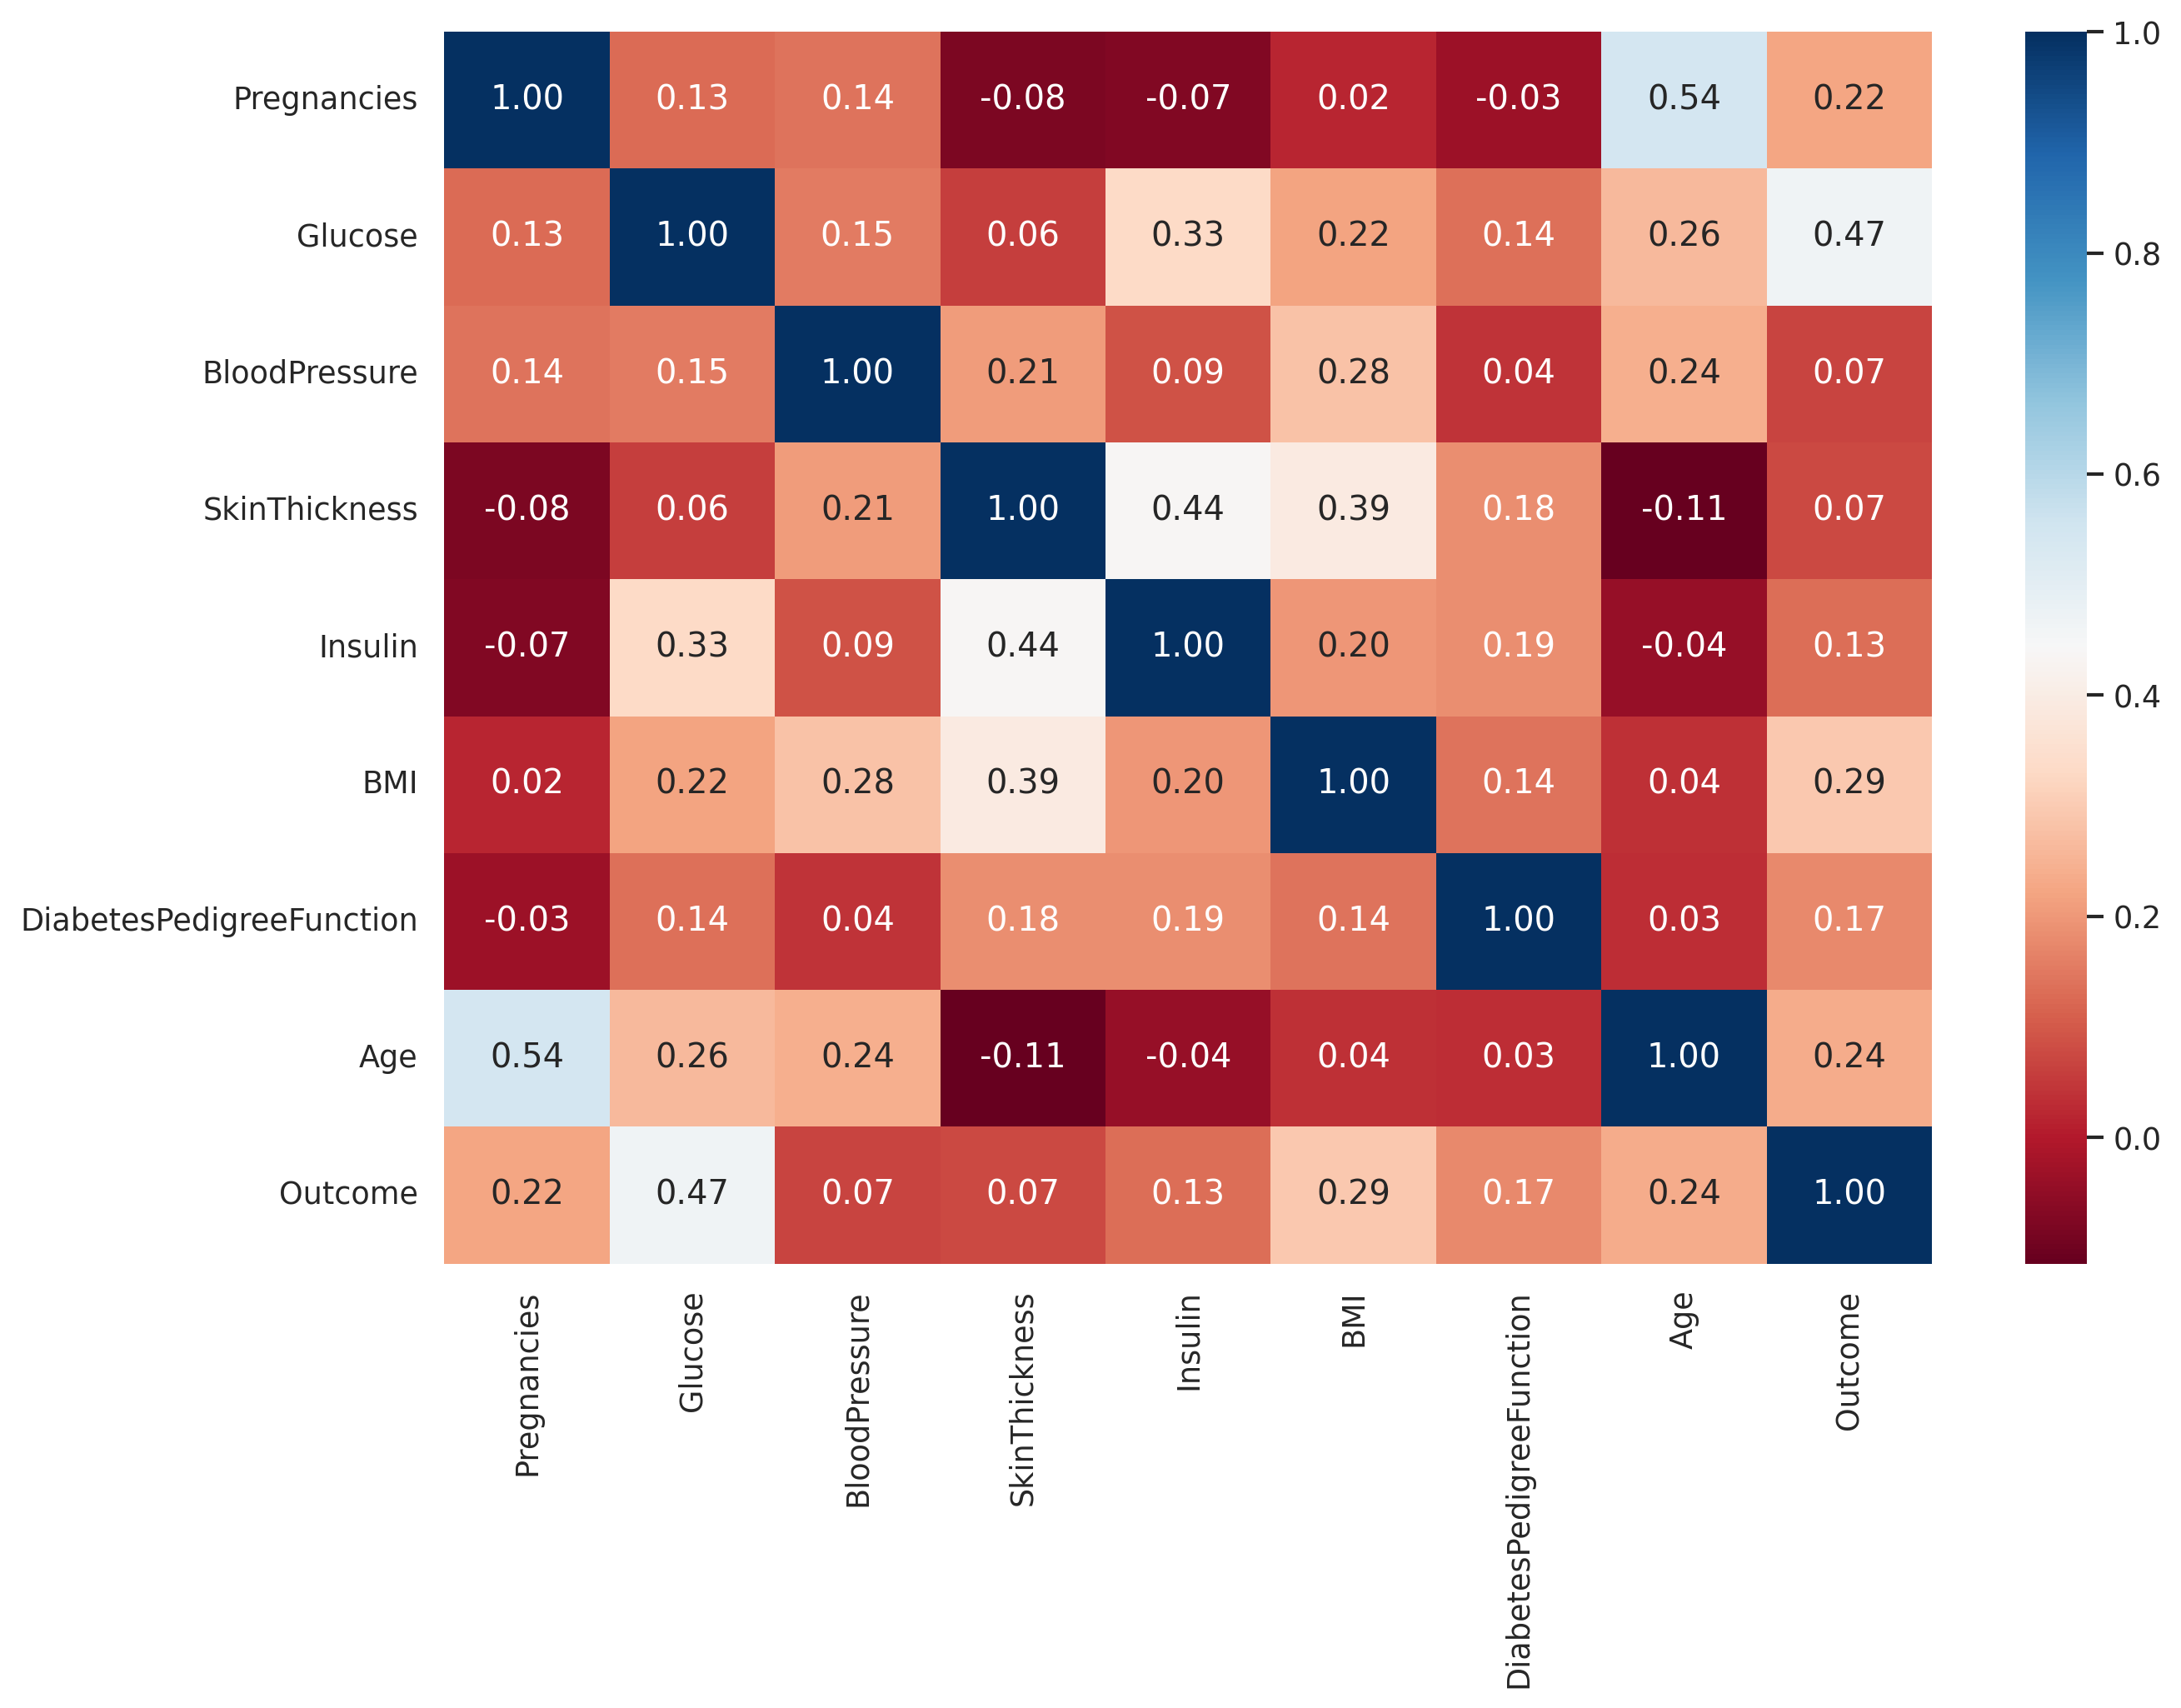

In [9]:
sns.set()
plt.figure(figsize=(12,8))
db1_cfm = sns.heatmap(diabetes_df.corr(), cmap="RdBu", annot=True, fmt=".2f")

In [10]:
def hist_plot(features, df_name):
    # number of features (excluding label column)
    Nrows=len(features.columns)-1

    # two features for per column
    Ncols=2

    fig, axes = plt.subplots((Nrows+1)//Ncols, Ncols, figsize=(8,12))
    plt.title(df_name.capitalize()+" group")

    for i,column in enumerate(features.columns[:-1]):
        row=i//Ncols
        col=i%Ncols
        sns.histplot(data=features, x=column, hue="Outcome", bins=30, kde=True, alpha=0.7,ax=axes[row,col], edgecolor=None)
        axes[row,col].set_title(f'{column} Histogram')
        axes[row,col].set_xlabel(f'{column} values')
        axes[row,col].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()


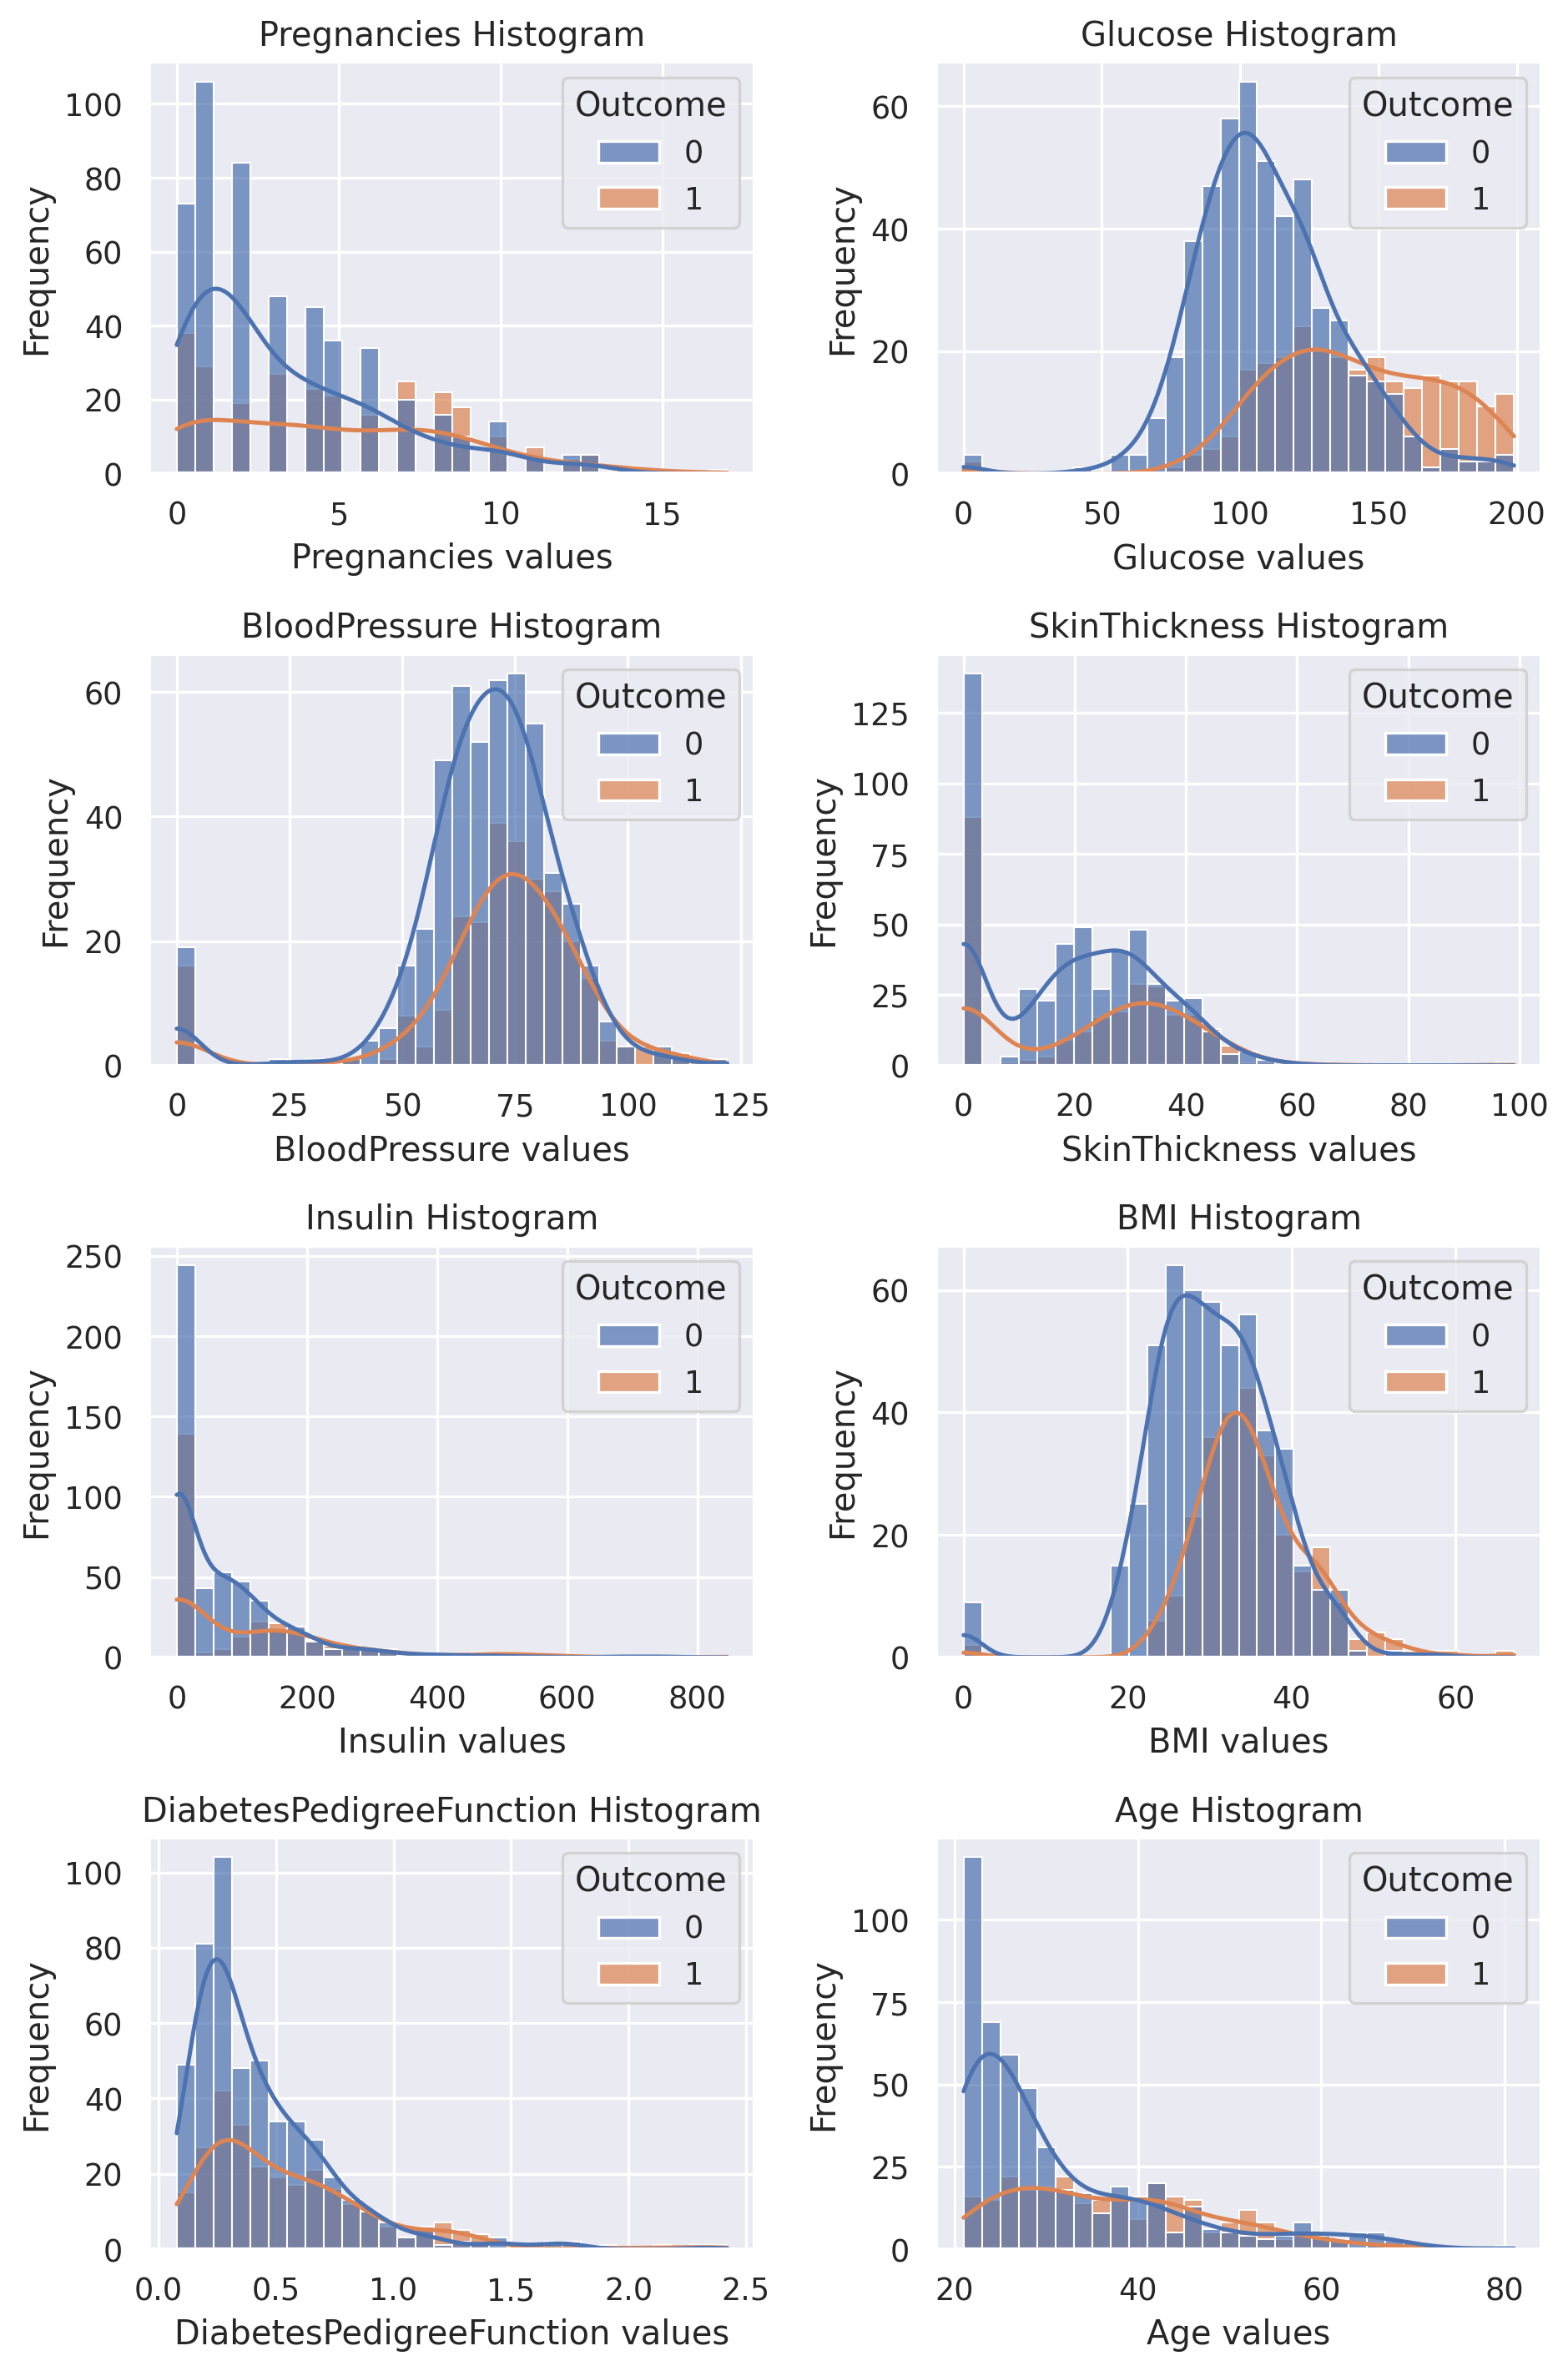

In [11]:
hist_plot(diabetes_df,"Features")

In [12]:
target=diabetes_df['Outcome']
features=diabetes_df.drop('Outcome',axis=1)
print(f'Feature names are : {features.columns}')

Feature names are : Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')


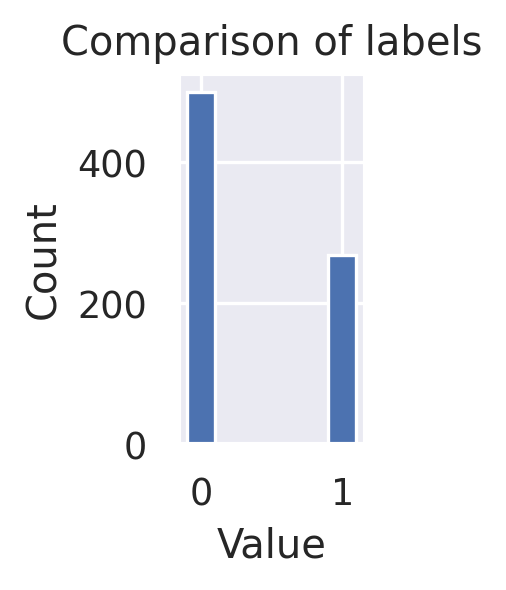

In [13]:
#count based on the labels
value_count= target.value_counts()

plt.figure(figsize=(1,2))

plt.bar(value_count.index,value_count.values,width=0.2)

plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Comparison of labels")
plt.show()

In [14]:
from sklearn.model_selection import train_test_split

print("Before split")
negative = np.count_nonzero(target == -1)
positive = np.count_nonzero(target == 1)
print(f'Label distribution percentage')
print(f'Raw dataset: Positive= {round(positive/len(target)*100,2)}%, Negative= {round((1-positive)/len(target)*100,2)}%')
print('-----------------------------------')

X_train,X_test,y_train,y_test = train_test_split(features,target,test_size=0.2,random_state=42, stratify=target)

positive_train=np.count_nonzero(y_train==1)
positive_test=np.count_nonzero(y_test==1)

print('After the split')
print(f'Train data size : {len(y_train)}')
print(f'Test data size : {len(y_test)}')

print('--------------------------------------')
print(f'Label distribution percentages')
print(f'Training: Positive= {round(positive_train/len(y_train)*100,2)}%, Negative= {round((len(y_train)-positive_train)/len(y_train)*100,2)}%')
print(f'Testing: Positive= {round(positive_test/len(y_test)*100,2)}%, Negative= {round((len(y_test)-positive_test)/len(y_test)*100,2)}%')


Before split
Label distribution percentage
Raw dataset: Positive= 34.9%, Negative= -34.77%
-----------------------------------
After the split
Train data size : 614
Test data size : 154
--------------------------------------
Label distribution percentages
Training: Positive= 34.85%, Negative= 65.15%
Testing: Positive= 35.06%, Negative= 64.94%


In [15]:
preprocess_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
X_train=preprocess_pipe.fit_transform(X_train)
X_test=preprocess_pipe.transform(X_test)

In [16]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(np.array(y_train), dtype=torch.float32).reshape(-1,1)
y_test = torch.tensor(np.array(y_test), dtype=torch.float32).reshape(-1,1)

In [17]:
class Perceptron(nn.Module):
    def __init__(self, input_size):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(input_size, 1)

    def forward(self, x):
        return torch.sigmoid(self.fc(x))

In [18]:
def train(model, X, y, num_epochs, learning_rate, batch_size=32, verbose = True, graph=True):
    model.train()
    criterion = nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    dataset = torch.utils.data.TensorDataset(X, y)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    accuracy_history = []
    loss_history = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            predicted_labels = (outputs >= 0.5).float()
            correct_predictions += (predicted_labels == labels).sum().item()
            total_samples += labels.size(0)

        # Calculate accuracy and loss for this epoch
        accuracy = correct_predictions / total_samples
        loss_epoch = running_loss / len(dataloader)

        # Append to history
        accuracy_history.append(accuracy)
        loss_history.append(loss_epoch)

        if epoch%(num_epochs//10)==(num_epochs//10)-1:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss : {running_loss/ len(dataloader)}")

    if verbose:
        print("Training done")
    if graph:
        graph_results(accuracy_history=accuracy_history,loss_history=loss_history, num_epochs=num_epochs)
        # graph_results(accuracy_history=accuracy2,loss_history=loss_history, num_epochs=num_epochs)

    return model, accuracy_history, loss_history


def graph_results(accuracy_history, loss_history, num_epochs):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(num_epochs), accuracy_history, label='Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Epochs')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(range(num_epochs), loss_history, label='Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epochs')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()


def evaluate_classification(predicted_labels, actual_labels, threshold=0.5):
    predicted_labels = (predicted_labels >= threshold).float()

    # Convert torch tensors to NumPy arrays for sklearn metrics
    predicted_labels = predicted_labels.numpy()
    actual_labels = actual_labels.numpy()

    # Calculating evaluation metrics
    accuracy = balanced_accuracy_score(actual_labels, predicted_labels)
    recall_case = recall_score(y_true=actual_labels, y_pred=predicted_labels, zero_division=0)
    precision_case = precision_score(y_true=actual_labels, y_pred=predicted_labels,zero_division=0)

    metrics = {
        "Accuracy": accuracy,
        "Recall": recall_case,
        "Precision": precision_case
    }

    return metrics

Epoch 25/250, Loss : 0.6625993430614472
Epoch 50/250, Loss : 0.668083444237709
Epoch 75/250, Loss : 0.6513886213302612
Epoch 100/250, Loss : 0.6489075541496276
Epoch 125/250, Loss : 0.643179389834404
Epoch 150/250, Loss : 0.6367179960012436
Epoch 175/250, Loss : 0.6366055130958557
Epoch 200/250, Loss : 0.6281354829668999
Epoch 225/250, Loss : 0.642990979552269
Epoch 250/250, Loss : 0.6299702227115631
Training done


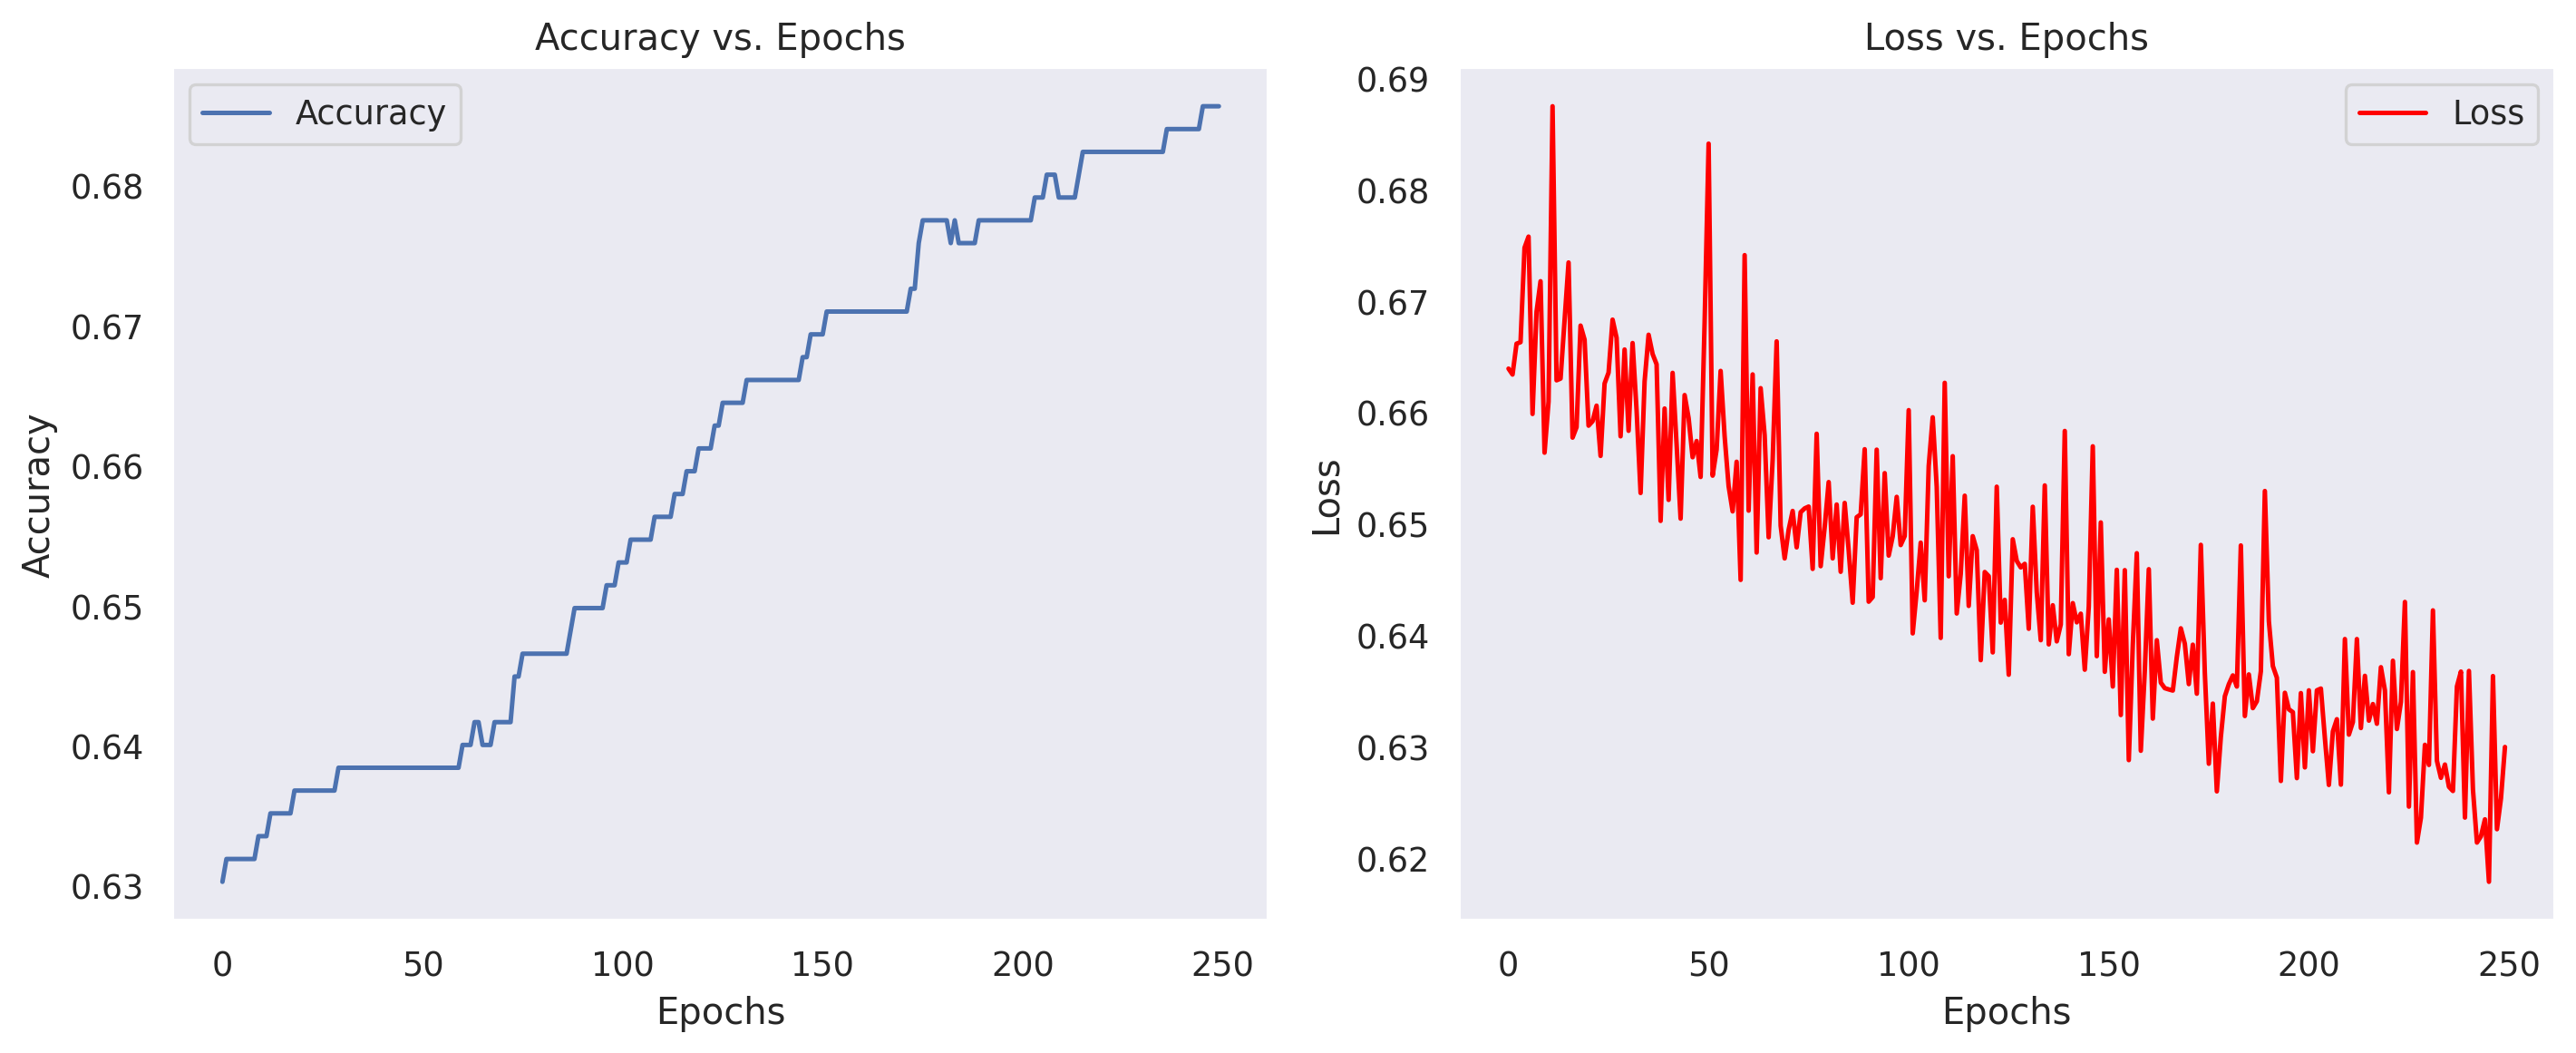

{'Accuracy': 0.6064814814814815,
 'Recall': 0.46296296296296297,
 'Precision': 0.5}

In [19]:
n_epochs = 250
batch_size = 32
model = Perceptron(X_train.shape[1])
trained_model, accuracy_history, loss_history = train(model=model, X=X_train, y=y_train, num_epochs=n_epochs, learning_rate=0.0001, batch_size=batch_size)
trained_model.eval()
y_pred = trained_model(X_test)
evaluate_classification(y_pred, y_test)

In [20]:
class MLP(nn.Module):
  def __init__(self, input_size, hidden_sizes, output_size=1):
    super(MLP, self).__init__()
    self.hidden_layers = nn.ModuleList()

    # Add hidden layers
    print(hidden_sizes)
    for hidden_size in hidden_sizes:
      print(hidden_size)
      self.hidden_layers.append(nn.Linear(input_size, hidden_size))
      self.hidden_layers.append(nn.ReLU())
      input_size = hidden_size

    self.output_layer = nn.Linear(input_size, output_size)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    for layer in self.hidden_layers:
      x = layer(x)
    x = self.output_layer(x)
    return self.sigmoid(x)


[128]
128
Epoch 25/250, Loss : 0.6695974856615067
Epoch 50/250, Loss : 0.6562204331159591
Epoch 75/250, Loss : 0.6441205471754075
Epoch 100/250, Loss : 0.6357259958982467
Epoch 125/250, Loss : 0.6262930691242218
Epoch 150/250, Loss : 0.6251409739255905
Epoch 175/250, Loss : 0.6151294231414794
Epoch 200/250, Loss : 0.5997090727090836
Epoch 225/250, Loss : 0.599551510810852
Epoch 250/250, Loss : 0.5891262978315354
Training done


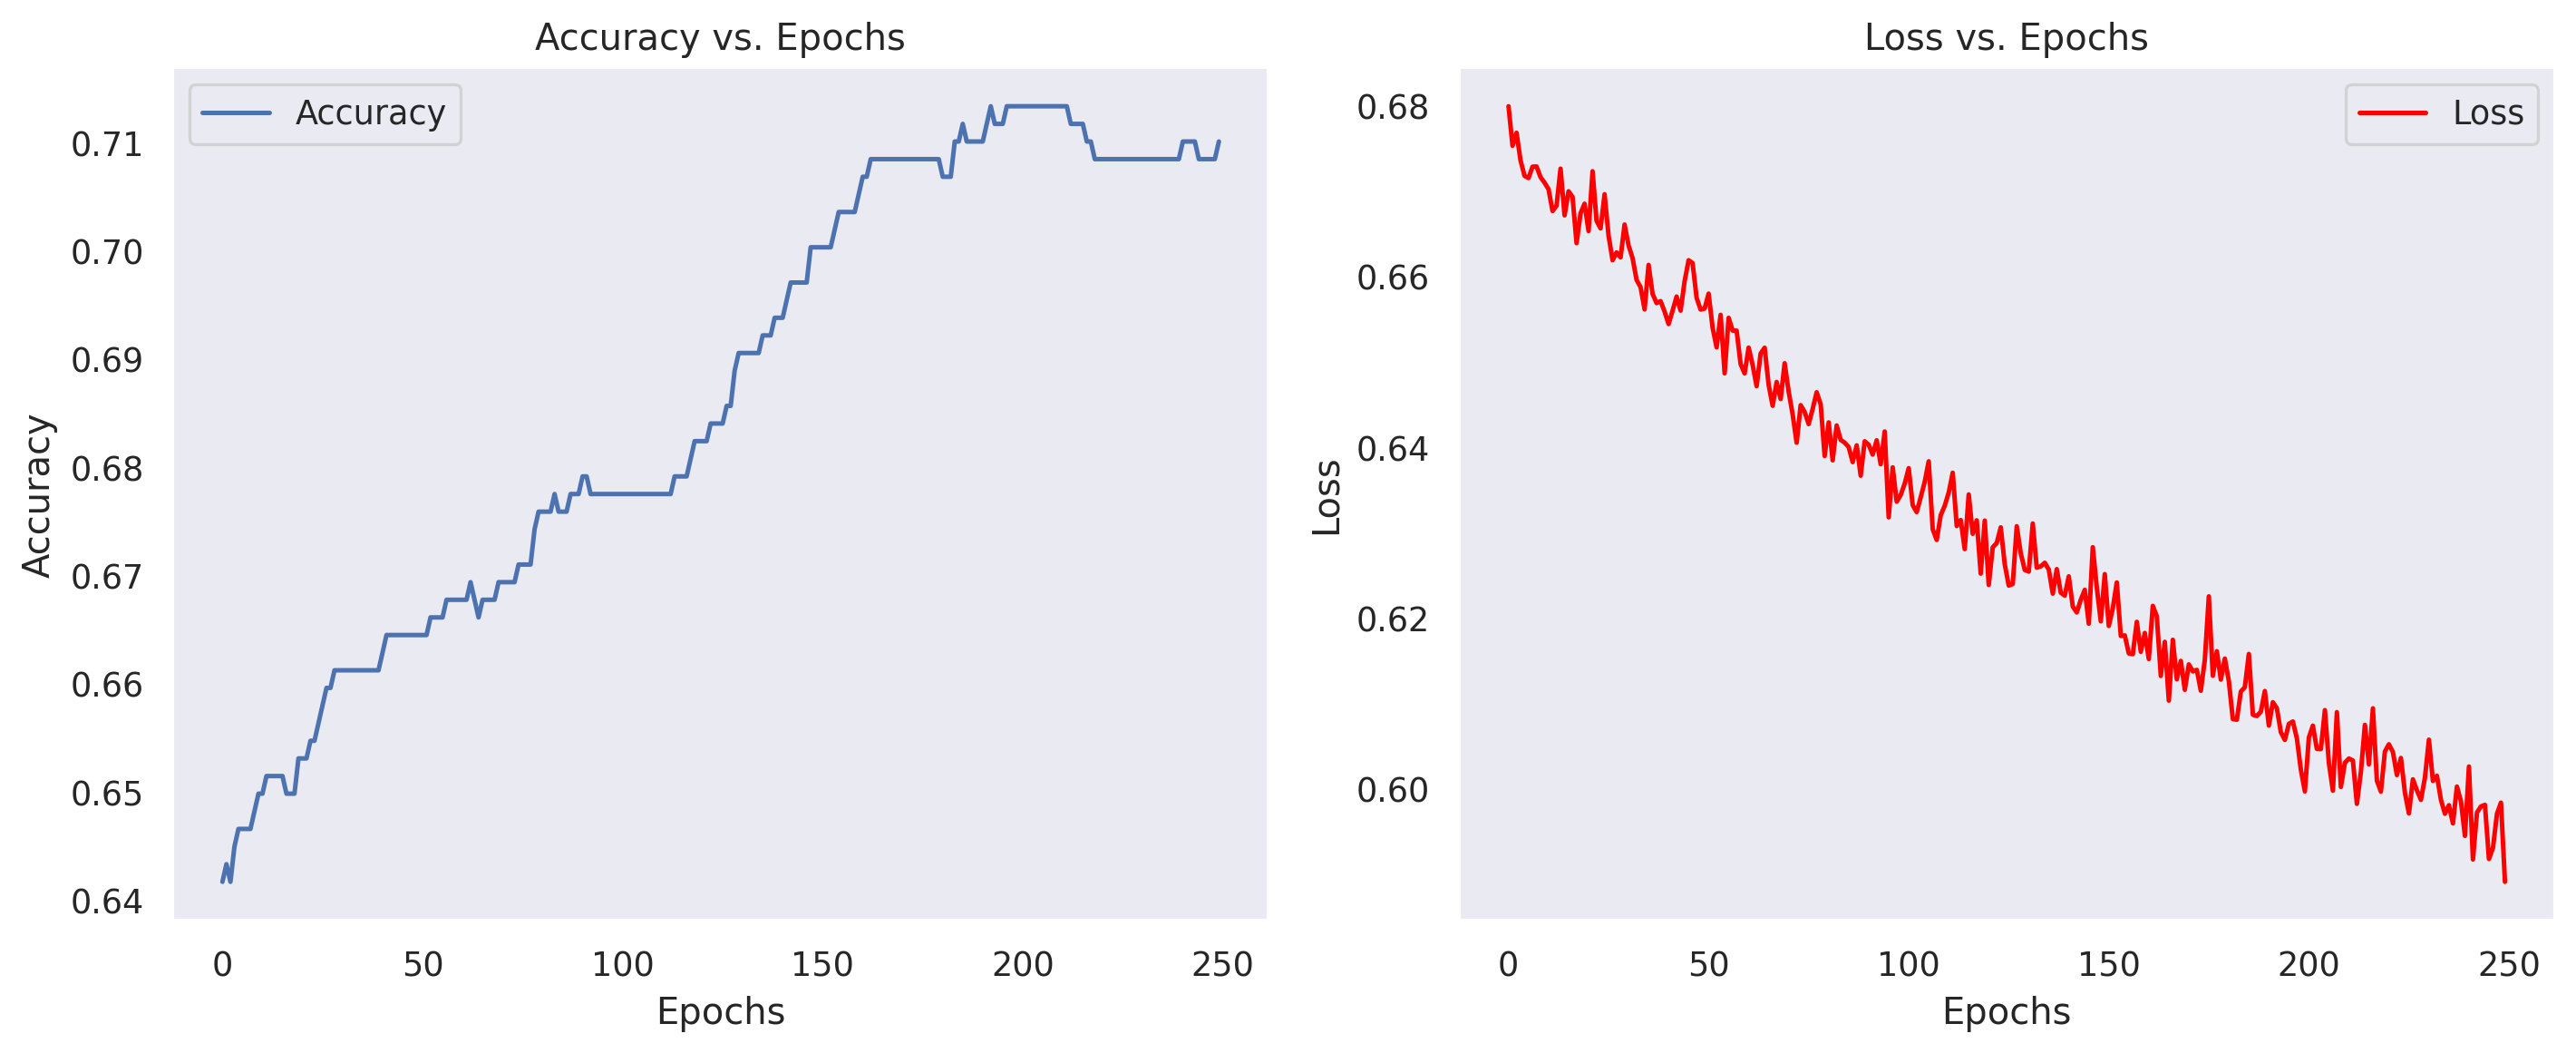

{'Accuracy': 0.596111111111111, 'Recall': 0.2222222222222222, 'Precision': 0.8}

In [21]:
n_epochs = 250
batch_size = 32
hidden_sizes=[128]
model_mlp = MLP(X_train.shape[1],hidden_sizes)
trained_model, accuracy_history, loss_history = train(model=model_mlp, X=X_train, y=y_train, num_epochs=n_epochs, learning_rate=0.0001, batch_size=batch_size)
trained_model.eval()
y_pred = trained_model(X_test)
evaluate_classification(y_pred, y_test)

In [22]:
from itertools import product
def tuning(X_tr,y_tr, X_t, y_t, parameters):
  input_size = X_train.shape[1]
  # output_size = 1

  combinations = list(product(*parameters.values()))
  # print(combinations)

  results = {}
  for iteration,combination in enumerate(combinations):
    print(combination)
    # print(iteration)
    hidden_sizes = combination[0]
    model_train = MLP(input_size, hidden_sizes)
    lr = combination[1]
    batch_size = combination[2]
    num_epochs = combination[3]
    trained_model, accuracy_history, loss_history = train(model=model_train, X=X_tr, y=y_tr, num_epochs=num_epochs, learning_rate=lr, batch_size=batch_size,graph=False)
    prediction = trained_model(X_t)
    metrics = evaluate_classification(prediction, y_t)
    results[iteration] = {'hidden_sizes': hidden_sizes,
                          'learning_rate': lr,
                          'batch_size': batch_size,
                          'epochs': num_epochs,
                          'accuracy': metrics['Accuracy']}

  results = pd.DataFrame.from_dict(results, orient='index')
  best_combination = results[results['accuracy'] == results['accuracy'].max()]
  if len(best_combination)>1:
    parameters={}
    for combination in best_combination:
      parameters['hidden_sizes']=combination['hidden_sizes']
      parameters['learning_rate']=combination['learning_rate']
      parameters['batch_size']=combination['batch_size']
      parameters['epochs']=combination['epochs']
    return tuning(X_tr,y_tr, X_t, y_t, parameters)
  print("Tuning complete")
  return best_combination


In [23]:
param_grid = {
        'hidden_sizes': [ [8],[16],[32],[64],[16, 8], [32, 16], [64,32],[32,16,8],[64,32,8]],
        'learning_rate': [0.01, 0.1, 0.05,0.001],
        'batch_size': [16, 32,64],
        'num_epochs': [100,150,200]
    }

best_combination = tuning(X_train,y_train, X_test, y_test, param_grid)

([8], 0.01, 16, 100)
[8]
8
Epoch 10/100, Loss : 0.5679251551628113
Epoch 20/100, Loss : 0.5137791029917889
Epoch 30/100, Loss : 0.488830817815585
Epoch 40/100, Loss : 0.4729589575376266
Epoch 50/100, Loss : 0.46395169313137347
Epoch 60/100, Loss : 0.4548710943796696
Epoch 70/100, Loss : 0.45377329603219646
Epoch 80/100, Loss : 0.4480840762456258
Epoch 90/100, Loss : 0.44340685965159
Epoch 100/100, Loss : 0.44509119464036745
Training done
([8], 0.01, 16, 150)
[8]
8
Epoch 15/150, Loss : 0.5614265081210014
Epoch 30/150, Loss : 0.5075118824457511
Epoch 45/150, Loss : 0.4824851331038353
Epoch 60/150, Loss : 0.4734204384760979
Epoch 75/150, Loss : 0.46594448120166093
Epoch 90/150, Loss : 0.4550857452245859
Epoch 105/150, Loss : 0.44902535279591876
Epoch 120/150, Loss : 0.45081630387367344
Epoch 135/150, Loss : 0.4427180362817569
Epoch 150/150, Loss : 0.4443460297890199
Training done
([8], 0.01, 16, 200)
[8]
8
Epoch 20/200, Loss : 0.5350715074783716
Epoch 40/200, Loss : 0.4711372263920613
Epo

In [25]:
best_combination

,hidden_sizes,learning_rate,batch_size,epochs,accuracy
275,"[32, 16, 8]",0.05,32,200,0.782407


[32, 16, 8]
32
16
8
Epoch 20/200, Loss : 0.5398287892341613
Epoch 40/200, Loss : 0.48071032464504243
Epoch 60/200, Loss : 0.4402065292000771
Epoch 80/200, Loss : 0.40736855417490003
Epoch 100/200, Loss : 0.3717871569097042
Epoch 120/200, Loss : 0.36223090887069703
Epoch 140/200, Loss : 0.3569185383617878
Epoch 160/200, Loss : 0.3349308788776398
Epoch 180/200, Loss : 0.2985105860978365
Epoch 200/200, Loss : 0.31066255979239943
Training done


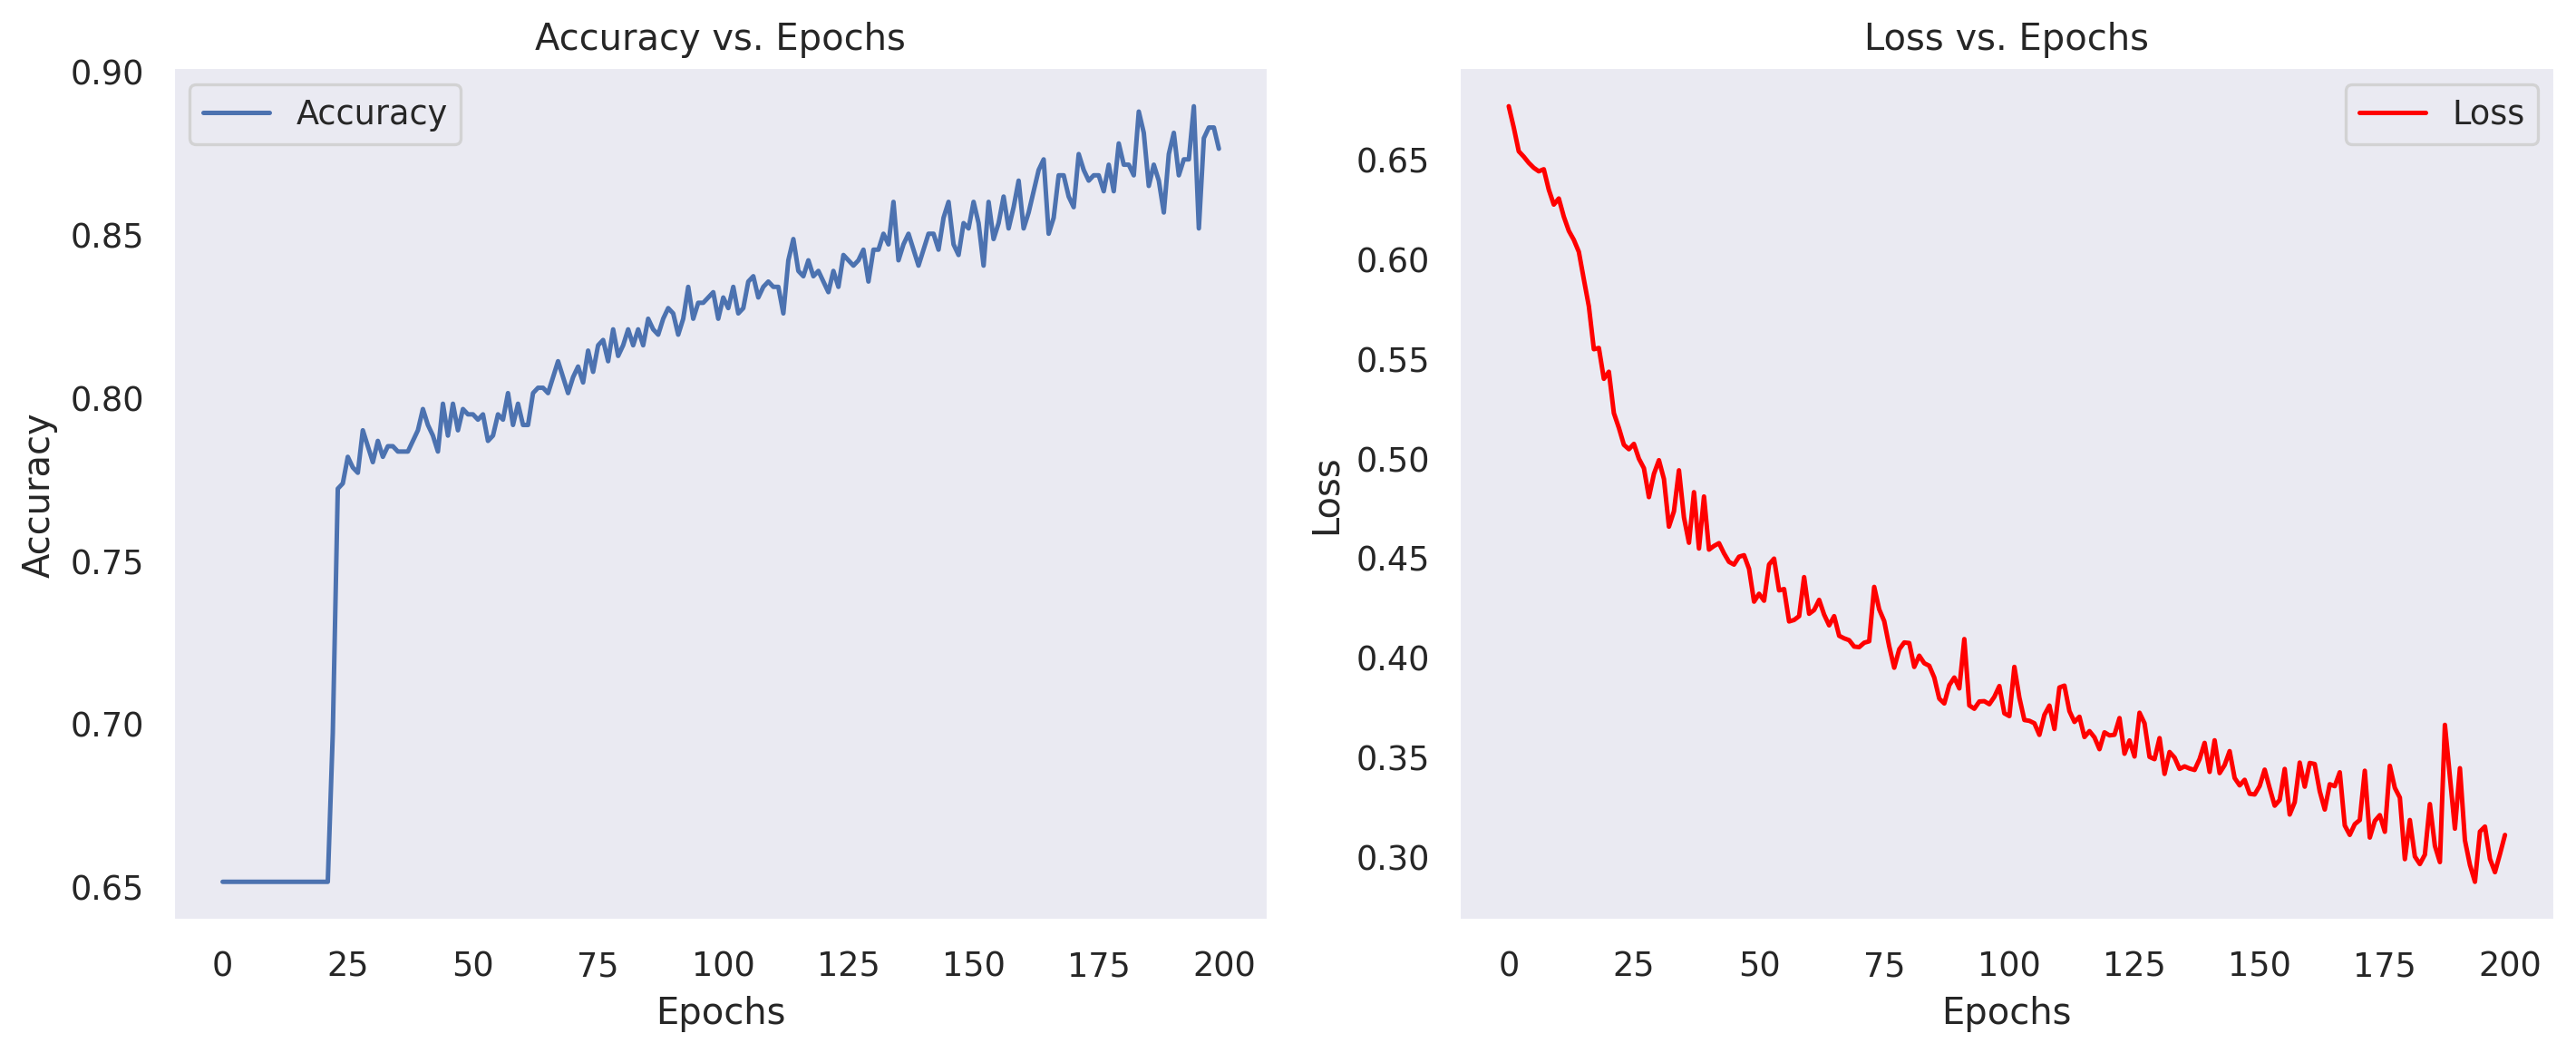

{'Accuracy': 0.7068518518518518,
 'Recall': 0.7037037037037037,
 'Precision': 0.5671641791044776}

In [26]:
n_epochs = 200
batch_size = 32
hidden_sizes=[32,16,8]
learning_rate = 0.05
model_mlp_tuned = MLP(X_train.shape[1],hidden_sizes)
tuned_model, accuracy_history, loss_history = train(model=model_mlp_tuned, X=X_train, y=y_train, num_epochs=n_epochs, learning_rate=learning_rate, batch_size=batch_size)
tuned_model.eval()
y_pred_tuned_1 = tuned_model(X_test)
evaluate_classification(y_pred_tuned_1, y_test)

[32]
32
Epoch 15/150, Loss : 0.42945989125814193
Epoch 30/150, Loss : 0.41755456572923905
Epoch 45/150, Loss : 0.4014764313514416
Epoch 60/150, Loss : 0.39115904653683686
Epoch 75/150, Loss : 0.3812576113985135
Epoch 90/150, Loss : 0.3678982062981679
Epoch 105/150, Loss : 0.35693763731381833
Epoch 120/150, Loss : 0.34565769900114107
Epoch 135/150, Loss : 0.3410488256277182
Epoch 150/150, Loss : 0.32615718226402235
Training done


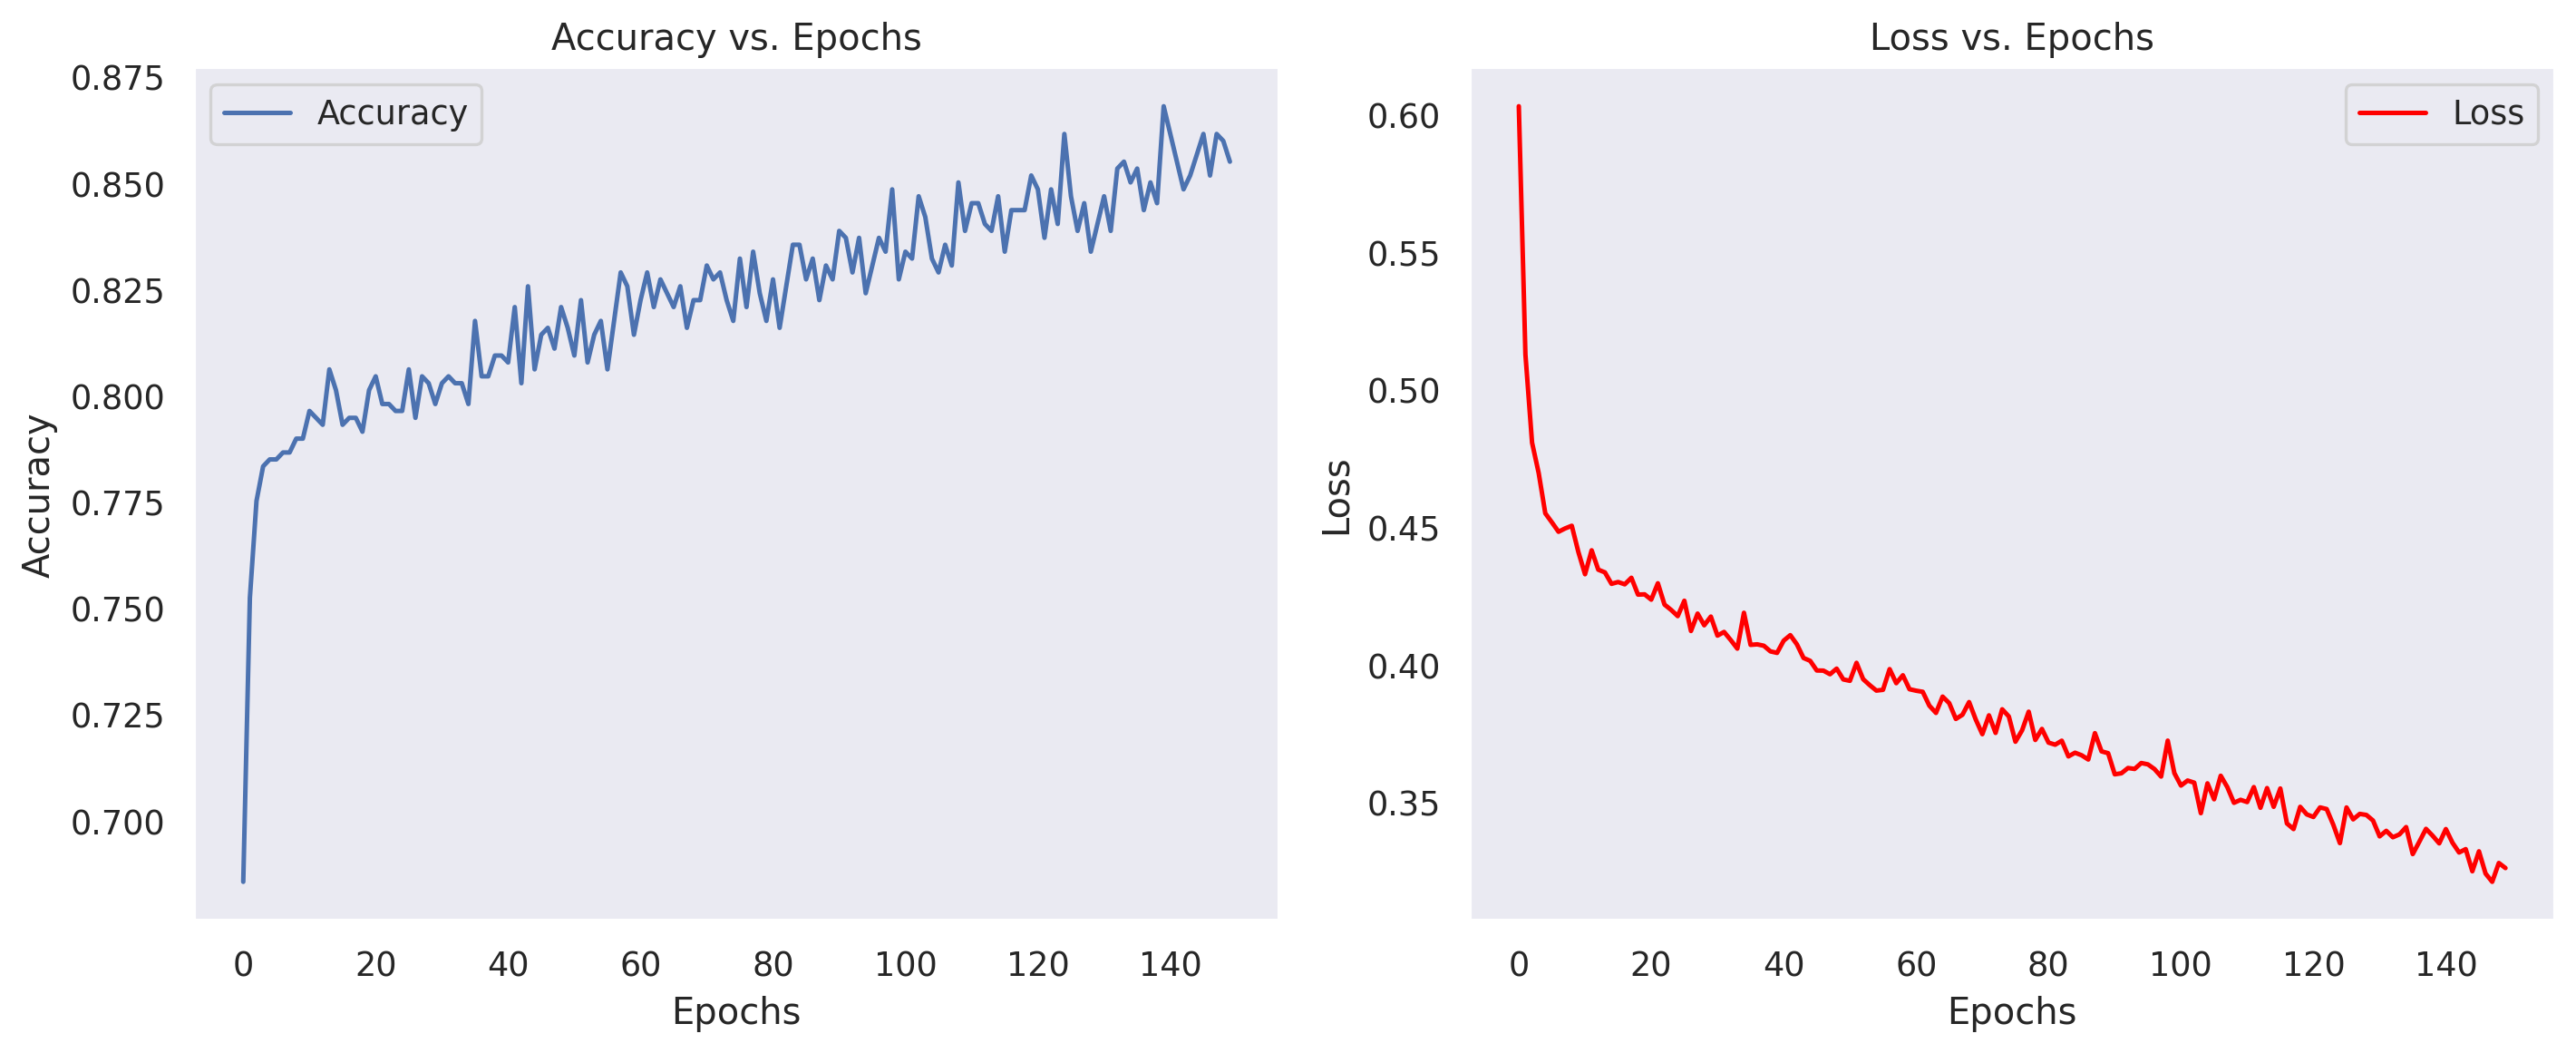

{'Accuracy': 0.6955555555555556,
 'Recall': 0.6111111111111112,
 'Precision': 0.6}

In [33]:
n_epochs = 150
batch_size = 16
hidden_sizes=[32]
learning_rate = 0.1
model_mlp_tuned = MLP(X_train.shape[1],hidden_sizes)
tuned_model_1, accuracy_history, loss_history = train(model=model_mlp_tuned, X=X_train, y=y_train, num_epochs=n_epochs, learning_rate=learning_rate, batch_size=batch_size)
tuned_model_1.eval()
y_pred_tuned = tuned_model_1(X_test)
evaluate_classification(y_pred_tuned, y_test)


In [32]:
tuned_model

MLP(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): ReLU()
  )
  (output_layer): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

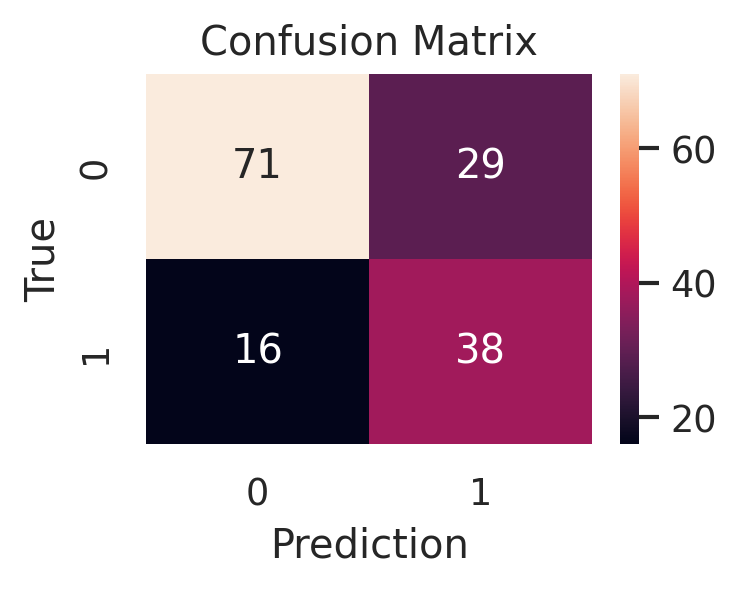

In [29]:
y_pred_tuned_1 = (y_pred_tuned_1 >= 0.5).float()
y_pred_tuned_1 = y_pred_tuned_1.numpy()
cmat = confusion_matrix(y_true=y_test, y_pred=y_pred_tuned_1)
plt.subplots(figsize=(3,2))
sns.heatmap(cmat,annot=True)
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()